# **From a coin-toss to the Greeks**
*Visualizations for understanding the derivation of option pricing*

In [1]:
# Library imports –––––
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
from matplotlib.patches import FancyArrowPatch
from matplotlib import colormaps
from matplotlib.colors import Normalize
from statistics import NormalDist
from mpl_toolkits.mplot3d import Axes3D

# Presettings –––––

# Color map
colours = {"1": '#481668',
           "2": '#f95d6a',
           "3": '#ff7c43',
           "4": '#ffa600',
           "5": '#B7DE28',
           "6": '#6ab04c',
           "7": '#20A286',
           "8": '#3E4788',
           "9": '#450C54'}

# LaTeX-style rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.unicode_minus": False,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

# Function to draw axis arrows
def axis_arrow(ax, start, end):
    ax.add_patch(FancyArrowPatch(start, end, arrowstyle='->',
                                 mutation_scale=8, lw=1, color='black',
                                 zorder=3, shrinkA=0, shrinkB=0))

## **I. Randomness in Finance: the Coin-toss Analogy**

In [3]:
# Functions for this section –––––

# Function to simulate symmetric random walk –––––
def symmetric_random_walk(n_steps=10):
    """Generate one symmetric random walk with ±1 steps."""
    steps = np.random.choice([-1, 1], size=n_steps)
    positions = np.cumsum(steps)
    x = np.arange(n_steps + 1)
    y = np.concatenate([[0], positions])
    return x, y

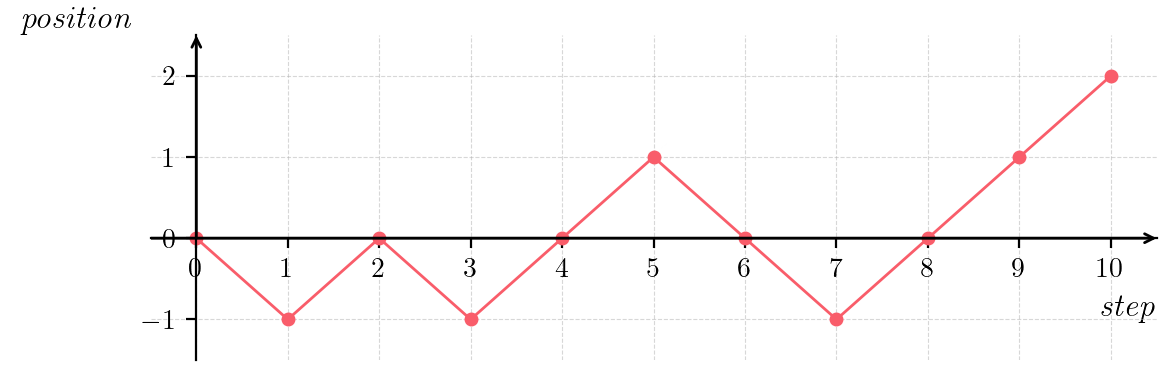

In [4]:
# Figure I.1: Symmetric Random Walk –––––

# Set random seed for reproducibility
np.random.seed(15)

# Simulate random walk
x, y = symmetric_random_walk(10)

# Plot setup
fig, ax = plt.subplots(figsize=(6, 2), dpi=200)
ax.plot(x, y, marker='o', markersize=4, linewidth=1, color=colours["2"])

# Clean axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.grid(True, linestyle='--', linewidth=0.4, alpha=0.5)

# Axis limits
xmin, xmax = -0.5, max(x) + 0.5
ymin, ymax = min(y) - 0.5, max(y) + 0.5
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Arrow heads
axis_arrow(ax, (xmin, 0), (xmax, 0))
axis_arrow(ax, (0, 0), (0, ymax))

# Show every integer on axis
ax.set_xticks(range(0, len(x)))
ax.set_yticks(range(int(ymin), int(ymax) + 1))

# Labels and title
ax.set_xlabel(r"\textit{step}", loc='right', fontsize=12)
ax.set_ylabel(r"\textit{position}", loc='top', rotation=0, fontsize=12)
#ax.set_title(r"\textbf{Symmetric Random Walk, } $n=10$", fontsize=13, pad=10)

# Save and show
plt.tight_layout()
plt.savefig("documentation/figures/symmetric-random-walk.pdf", dpi=300)
plt.show()


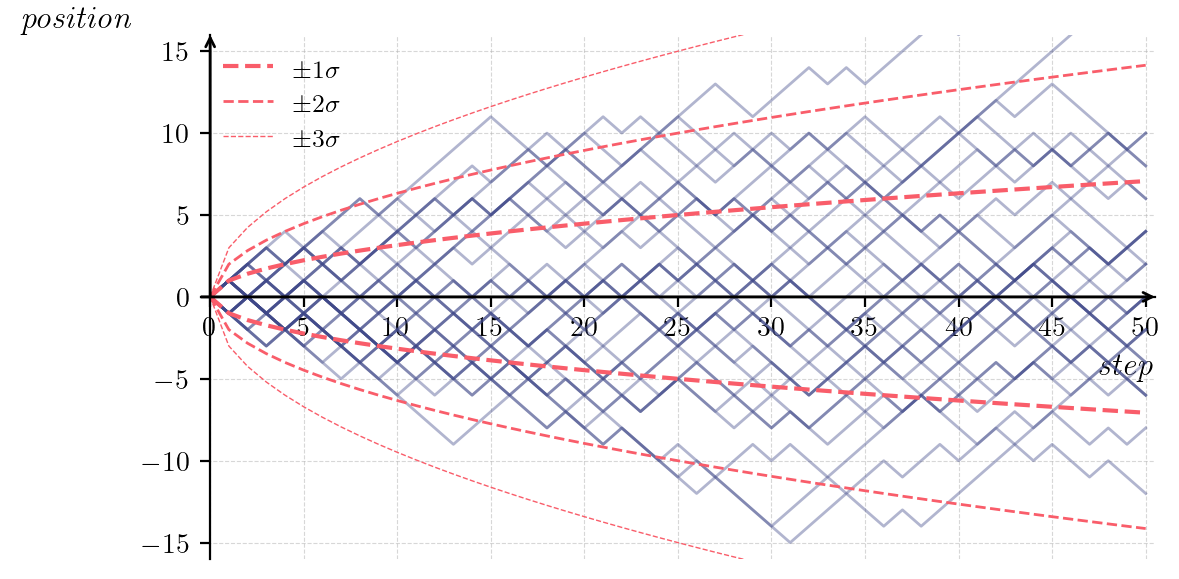

In [5]:
# Figure I.2: Growth of Uncertainty in Symmetric Random Walk –––––

# Set random seed for reproducibility
np.random.seed(15)

# Parameters
n_steps = 50
n_paths = 30

# Simulate multiple paths
paths = [symmetric_random_walk(n_steps)[1] for _ in range(n_paths)]
x = np.arange(n_steps + 1)

# Compute theoretical standard deviations
sigma_1 = np.sqrt(x)
sigma_2 = 2 * np.sqrt(x)
sigma_3 = 3 * np.sqrt(x)

# Plot
fig, ax = plt.subplots(figsize=(6, 3), dpi=200)

# Draw all random walks (with varying opacity for intuition of randomness)
for y in paths:
    ax.plot(x, y, color=colours["8"], alpha=0.4, linewidth=1)

# Plot ±σ, ±2σ, ±3σ envelopes
ax.plot(x,  sigma_1, color=colours["2"],  linestyle='--', linewidth=1.5, label=r'$\pm 1\sigma$')
ax.plot(x, -sigma_1, color=colours["2"],  linestyle='--', linewidth=1.5)
ax.plot(x,  sigma_2, color=colours["2"], linestyle='--',  linewidth=1.0, label=r'$\pm 2\sigma$')
ax.plot(x, -sigma_2, color=colours["2"], linestyle='--',  linewidth=1.0)
ax.plot(x,  sigma_3, color=colours["2"], linestyle='--',  linewidth=0.5, label=r'$\pm 3\sigma$')
ax.plot(x, -sigma_3, color=colours["2"], linestyle='--',  linewidth=0.5)

# Clean axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.grid(True, linestyle='--', linewidth=0.4, alpha=0.5)

# Axis limits
xmin, xmax = -0.5, n_steps + 0.5
ymin, ymax = -int(max(sigma_2) + 2), int(max(sigma_2) + 2)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Arrow heads
axis_arrow(ax, (xmin, 0), (xmax, 0))
axis_arrow(ax, (0, 0), (0, ymax))

# Show every fifth integer on x-axis
ax.set_xticks(range(0, n_steps + 1, 5))

# Labels and title
ax.set_xlabel(r"\textit{step}", loc='right', fontsize=12)
ax.set_ylabel(r"\textit{position}", loc='top', rotation=0, fontsize=12)
#ax.set_title(r"\textbf{Growth of Uncertainty in a Symmetric Random Walk}", fontsize=13, pad=10)
ax.legend(loc='upper left', frameon=False, fontsize=9)

# Save and show
plt.tight_layout()
plt.savefig("documentation/figures/symmetric-random-walk-uncertainty.pdf", dpi=300)
plt.show()


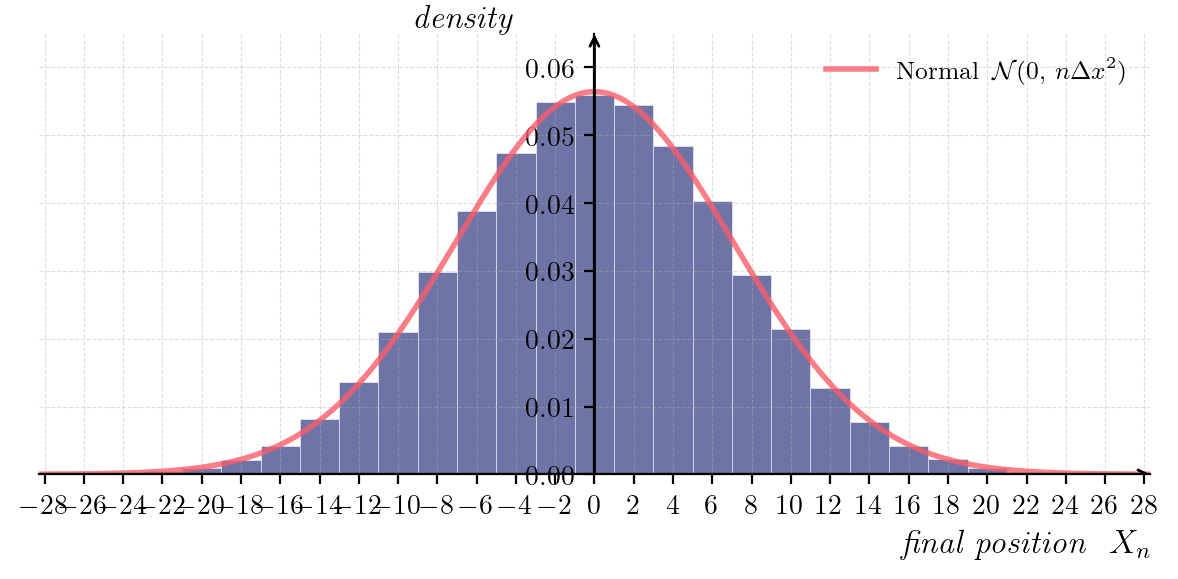

In [6]:
# Figure I.3: Distribution of Final Positions after Many Symmetric Random Walks –––––

# Set random seed for reproducibility
np.random.seed(15)

# Parameters
n = 50
n_paths = 40_000
mu = 0
sigma = np.sqrt(n)

# Simulate endpoints
final_positions = np.fromiter(
    (symmetric_random_walk(n)[1][-1] for _ in range(n_paths)),
    dtype=int, count=n_paths
)

# Define bins for histogram
bins = np.arange(-n - 1, n + 2, 2)

# Figure setup
fig, ax = plt.subplots(figsize=(6, 3), dpi=200)

# Histogram
ax.hist(final_positions, bins=bins, density=True,
        alpha=0.75, edgecolor='white', color=colours["8"], linewidth=0.25)

# Normal overlay
x_pdf = np.linspace(-4*sigma, 4*sigma, 600)
ax.plot(x_pdf, norm.pdf(x_pdf, loc=mu, scale=sigma), linewidth=2, color=colours["2"], alpha=0.8,
        label=r'Normal $\,\mathcal{N}(0,\,n\Delta x^2)$')

# Clean axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Vector arrows (no occlusion)
xmin, xmax = -4*sigma, 4*sigma
ymax = max(0.001 + ax.get_ylim()[1], norm.pdf(0, mu, sigma)*1.15)
ax.set_xlim(xmin, xmax)
ax.set_ylim(0, ymax)
axis_arrow(ax, (xmin, 0), (xmax, 0))
axis_arrow(ax, (0, 0), (0, ymax))

# Grid & ticks
ax.grid(True, linestyle='--', linewidth=0.4, alpha=0.4)
xticks = np.arange(np.ceil(xmin), np.floor(xmax)+1, 2)
ax.set_xticks(xticks.astype(int))
#ax.set_yticks(np.linspace(0, ymax, 6))

# Labels & title
ax.set_xlabel(r"\textit{final position } $X_n$", loc='right', fontsize=12)
ax.set_ylabel(r"\textit{density}", loc='top', rotation=0, fontsize=12)
#ax.set_title(rf"\textbf{{Distribution of }} $X_n$ \textbf{{ after }} $n={n}$ \textbf{{ steps}}", fontsize=13, pad=10)
ax.legend(frameon=False, fontsize=9, loc='upper right')

# Save and show
plt.tight_layout()
plt.savefig("documentation/figures/symmetric-random-walk-distribution.pdf", dpi=300)
plt.show()


## **II. From Random Walk to Brownian Motion**

In [7]:
# Functions for this section –––––

# Symmetric random walk to approximate Brownian motion
def symmetric_random_walk_to_T(T=1.0, dt=0.1, sigma=1.0):
    """
    Simulate a symmetric random walk over [0, T] with step time dt.
    Steps are ±Δx with Δx = sigma * sqrt(dt) to preserve Var[X(T)] = sigma^2 T.
    Returns time grid and positions (including initial 0).
    """
    n_steps = int(np.round(T / dt))
    dt = T / n_steps  # ensure exact division
    delta_x = sigma * np.sqrt(dt)
    steps = np.random.choice([-delta_x, delta_x], size=n_steps)
    positions = np.concatenate([[0.0], np.cumsum(steps)])
    t = np.linspace(0.0, T, n_steps + 1)
    return t, positions

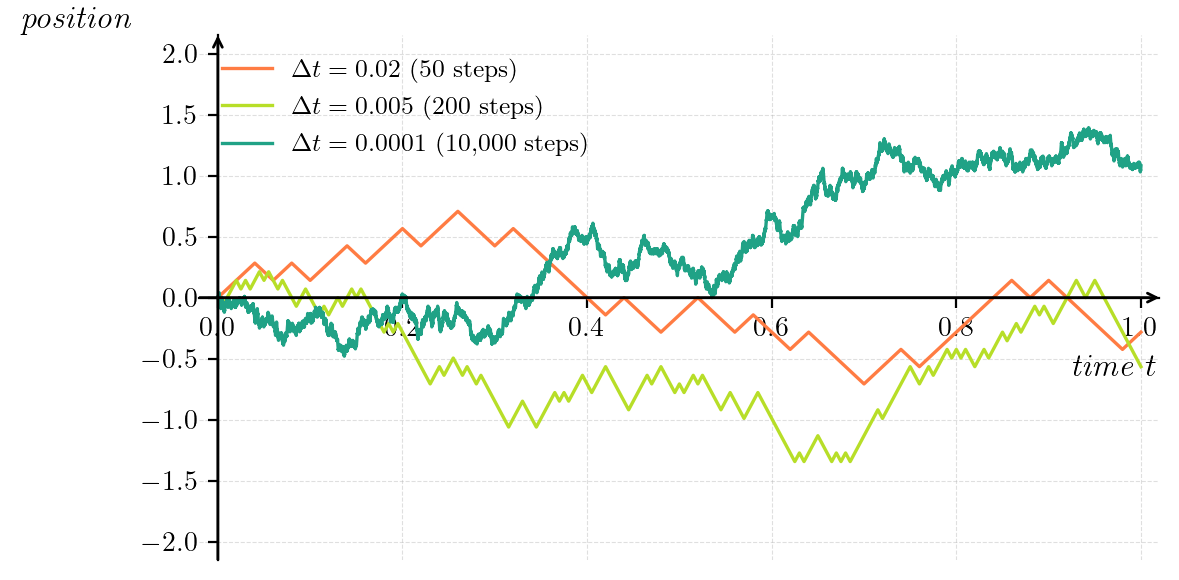

In [8]:
# Figure II.1: From Discrete to Continuous Symmetric Random Walks as Δt → 0 –––––

# Set random seed for reproducibility
np.random.seed(10)

# Parameters
T = 1.0
sigma = 1.0

# Decreasing time steps
dts = [0.02, 0.005, 0.0001]  # coarse to fine
labels = [r'$\Delta t=0.02$ (50 steps)',
          r'$\Delta t=0.005$ (200 steps)',
          r'$\Delta t=0.0001$ (10,000 steps)']

# Prepare figure
fig, ax = plt.subplots(figsize=(6, 3), dpi=200)

# Color map
colors = [colours["3"], colours["5"], colours["7"]]

# Plot the three paths
for i, dt in enumerate(dts):
    t, y = symmetric_random_walk_to_T(T=T, dt=dt, sigma=sigma)
    ax.plot(t, y, color=colors[i], linewidth=1.2, label=labels[i])

# Clean axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')


# Limits and vector arrows
xmin, xmax = -0.02, T + 0.02
# Theoretical 2σ envelope at T for reference (not plotted), set y-lims symmetrically
y_lim = sigma * np.sqrt(T) * 2.15
ax.set_xlim(xmin, xmax)
ax.set_ylim(-y_lim, y_lim)
axis_arrow(ax, (xmin, 0), (xmax, 0))
axis_arrow(ax, (0, -y_lim), (0, y_lim))

# Grid & ticks
ax.grid(True, linestyle='--', linewidth=0.4, alpha=0.4)
ax.set_xticks(np.linspace(0, T, 6))
ax.set_yticks(np.linspace(-2.0, 2.0, 9))  # symmetric ticks around 0

# Labels & title
ax.set_xlabel(r"\textit{time} $t$", loc='right', fontsize=12)
ax.set_ylabel(r"\textit{position}", loc='top', rotation=0, fontsize=12)
#ax.set_title(r"\textbf{From Discrete to Continuous: Symmetric Random Walks as } $\Delta t \to 0$", fontsize=13, pad=10)
# legend a little to the right

ax.legend(loc='upper left', frameon=False, fontsize=9)

# Save and show
plt.tight_layout()
plt.savefig("documentation/figures/symmetric-random-walk-continuum-limit.pdf", dpi=300)
plt.show()


## **III. The Stochastic Process with Drift and Diffusion**

In [9]:
# Functions for this section –––––

# Simulate Brownian motion
def brownian_motion(T=1.0, n_steps=1000, sigma=1.0):
    """Generate one Brownian motion path with given σ."""
    dt = T / n_steps
    dW = np.random.normal(0, np.sqrt(dt), n_steps)
    W = np.concatenate([[0], np.cumsum(dW)]) * sigma
    t = np.linspace(0, T, n_steps + 1)
    return t, W

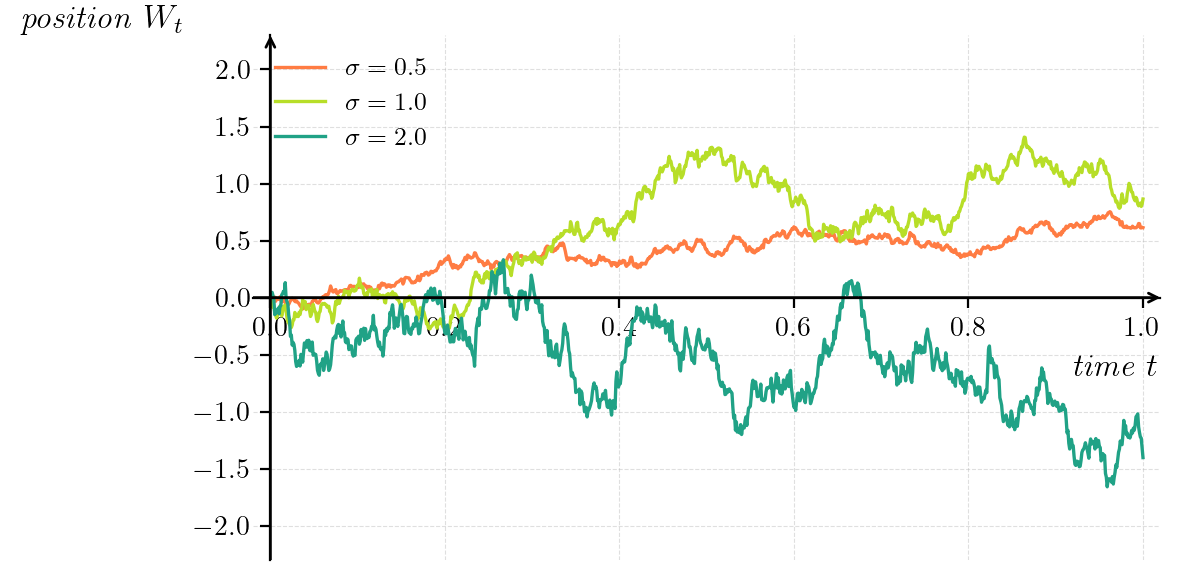

In [10]:
# Figure III.1: Scaled Brownian Motions with Different Volatilities σ –––––


# Set random seed for reproducibility
np.random.seed(1)

# Parameters
T = 1.0
n_steps = 1000
t = np.linspace(0, T, n_steps + 1)
dt = T / n_steps

# Volatility levels
sigmas = [0.5, 1.0, 2.0]
colors = [colours["3"], colours["5"], colours["7"]]
labels = [r'$\sigma=0.5$', r'$\sigma=1.0$', r'$\sigma=2.0$']

# Prepare figure
fig, ax = plt.subplots(figsize=(6, 3), dpi=200)

# Plot Brownian motions for each sigma
for sigma, color, label in zip(sigmas, colors, labels):
    t, W = brownian_motion(T, n_steps, sigma)
    ax.plot(t, W, color=color, linewidth=1.2, label=label)

# Clean axes (same style)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Axis limits and arrows
xmin, xmax = -0.02, T + 0.02
y_lim = max(sigmas) * np.sqrt(T) * 1.15
ax.set_xlim(xmin, xmax)
ax.set_ylim(-y_lim, y_lim)
axis_arrow(ax, (xmin, 0), (xmax, 0))
axis_arrow(ax, (0, -y_lim), (0, y_lim))

# Grid and ticks
ax.grid(True, linestyle='--', linewidth=0.4, alpha=0.4)
ax.set_xticks(np.linspace(0, T, 6))
ax.set_yticks(np.linspace(-2, 2, 9))

# Title, labels and legend
ax.set_xlabel(r"\textit{time} $t$", loc='right', fontsize=12)
ax.set_ylabel(r"\textit{position} $W_t$", loc='top', rotation=0, fontsize=12)
#ax.set_title(r"\textbf{Scaled Brownian Motions with Different Volatilities } $\sigma$", fontsize=13, pad=10)
ax.legend(loc='upper left', frameon=False, fontsize=9)

# Save and show
plt.tight_layout()
plt.savefig("documentation/figures/scaled-brownian-motions.pdf", dpi=300)
plt.show()

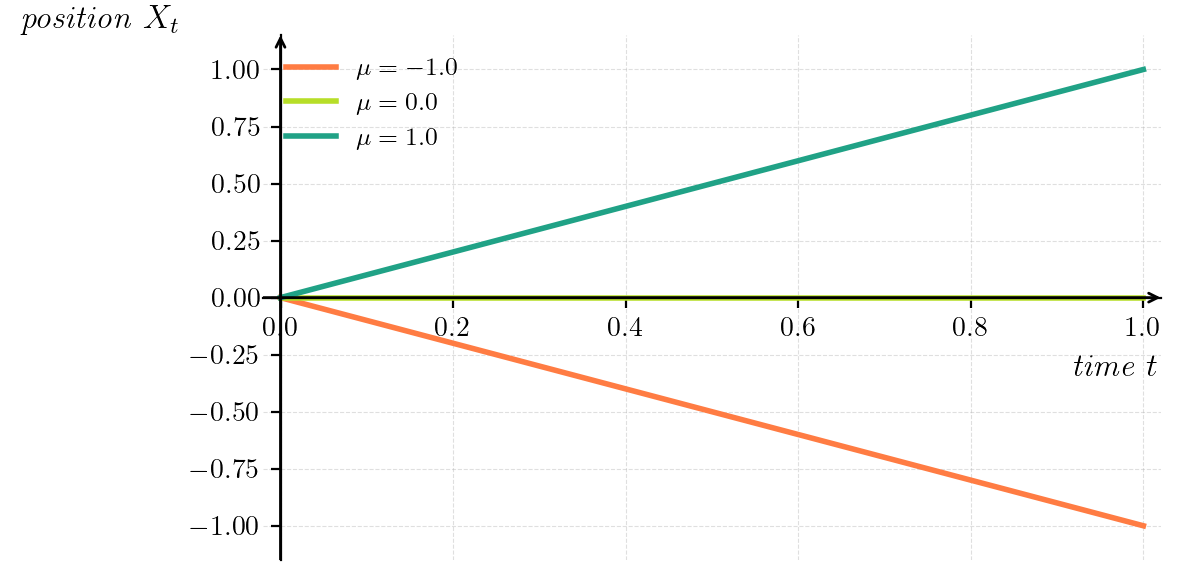

In [11]:
# Figure III.2: Pure Drift Processes with Different Drift Parameters μ –––––

# Parameters
T = 1.0
n_steps = 1000
t = np.linspace(0, T, n_steps + 1)

# Drift levels
mus = [-1.0, 0.0, 1.0]
colors = [colours["3"], colours["5"], colours["7"]]
labels = [r'$\mu=-1.0$', r'$\mu=0.0$', r'$\mu=1.0$']

# Initial value
X0 = 0.0

# Prepare figure
fig, ax = plt.subplots(figsize=(6, 3), dpi=200)

# Plot deterministic drift lines
for mu, color, label in zip(mus, colors, labels):
    X = X0 + mu * t
    ax.plot(t, X, color=color, linewidth=2, label=label)

# Clean axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Axis limits and arrows
xmin, xmax = -0.02, T + 0.02
y_lim = max(abs(mu) for mu in mus) * T * 1.15
ax.set_xlim(xmin, xmax)
ax.set_ylim(-y_lim, y_lim)
axis_arrow(ax, (xmin, 0), (xmax, 0))
axis_arrow(ax, (0, -y_lim), (0, y_lim))

# Grid and ticks
ax.grid(True, linestyle='--', linewidth=0.4, alpha=0.4)
ax.set_xticks(np.linspace(0, T, 6))
ax.set_yticks(np.linspace(-1, 1, 9))

# Labels and legend
ax.set_xlabel(r"\textit{time} $t$", loc='right', fontsize=12)
ax.set_ylabel(r"\textit{position} $X_t$", loc='top', rotation=0, fontsize=12)
#ax.set_title(r"\textbf{Pure Drift Processes with Different Drift Parameters } $\mu$", fontsize=13, pad=10)
ax.legend(loc='upper left', frameon=False, fontsize=9)

# Save and show
plt.tight_layout()
plt.savefig("documentation/figures/pure-drift-processes.pdf", dpi=300)
plt.show()


## **IV. From Ordinary to Stochastic Calculus**

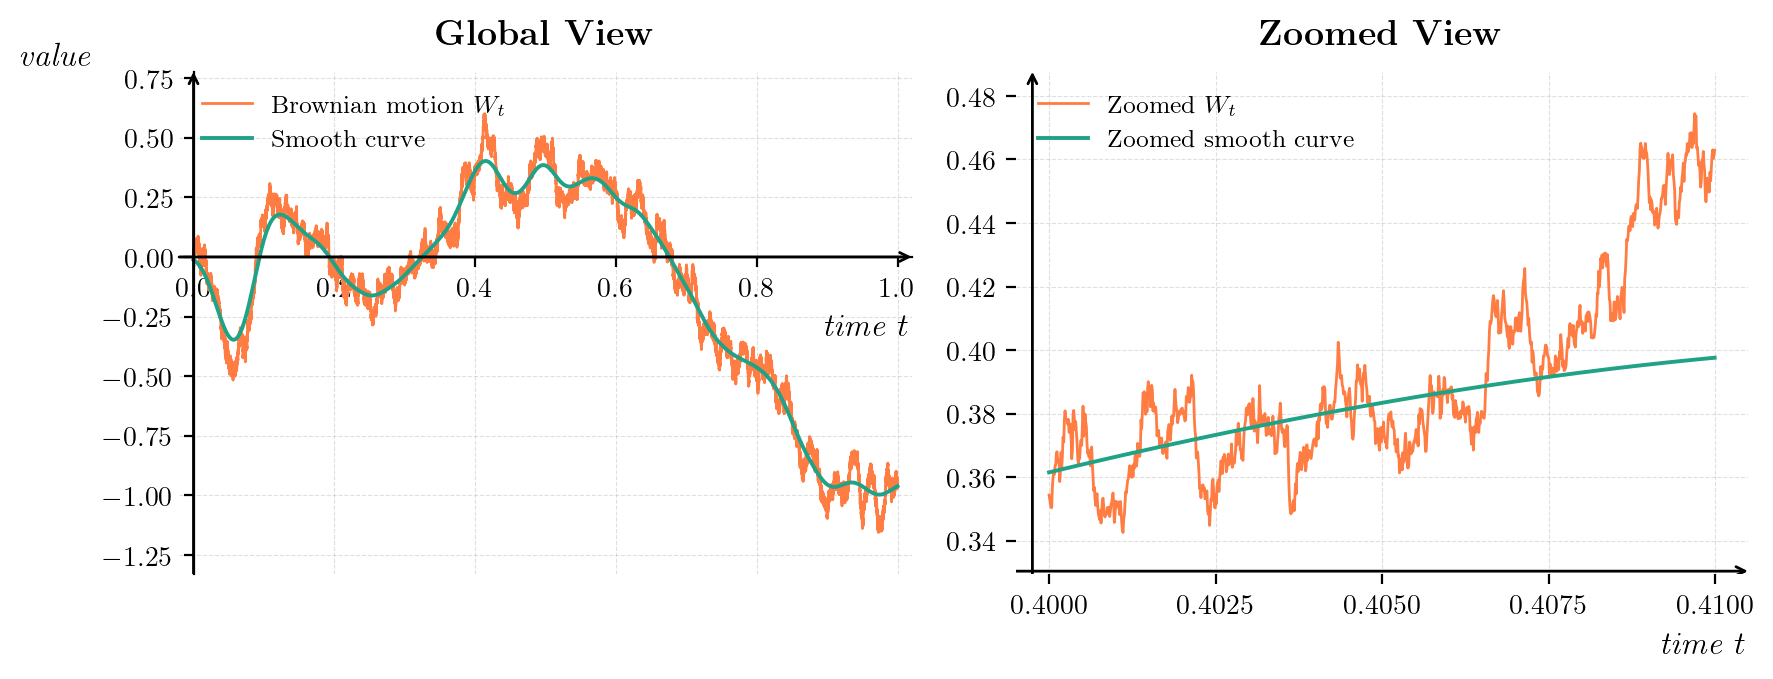

In [12]:
# Figure IV.1: Smooth Curve vs. Brownian Motion — Global vs. Zoom –––––

# Set random seed for reproducibility
np.random.seed(10)

# Parameters
T = 1.0
n_steps = 100000

# Generate one Brownian path
t, W = brownian_motion(T=T, n_steps=n_steps, sigma=1.0)

# Smooth "look-alike" (differentiable) path from the BM with Gaussian smoothing
sigma_smooth = 1600
W_smooth = gaussian_filter1d(W, sigma=sigma_smooth, mode='nearest')

# Zoom window
t0, t1 = 0.40, 0.41
mask = (t >= t0) & (t <= t1)
tz = t[mask]
Wz = W[mask]
Wz_smooth = W_smooth[mask]


# Figure
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5), dpi=200)

# Left: Global view
ax = axes[0]
ax.plot(t, W, color=colours["3"], linewidth=1.0, label=r"Brownian motion $W_t$")
ax.plot(t, W_smooth, color=colours["7"], linewidth=1.4, label=r"Smooth curve")

# Clean axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Axis limits and arrows
xmin, xmax = -0.02, T + 0.02
y_pad = 0.1 * (W.max() - W.min())
ymin, ymax = W.min() - y_pad, W.max() + y_pad
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
axis_arrow(ax, (xmin, 0), (xmax, 0))
axis_arrow(ax, (0, ymin), (0, ymax))

# Grid and ticks
ax.grid(True, linestyle='--', linewidth=0.4, alpha=0.4)
ax.set_xticks(np.linspace(0, T, 6))
#ax.set_yticks([])
ax.set_xlabel(r"\textit{time} $t$", loc='right', fontsize=12)
ax.set_ylabel(r"\textit{value}", loc='top', rotation=0, fontsize=12)
ax.set_title(r"\textbf{Global View}", fontsize=13, pad=10)
ax.legend(loc='upper left', frameon=False, fontsize=9)

# Right: Zoomed view
ax = axes[1]
ax.plot(tz, Wz, color=colours["3"], linewidth=1.0, label=r"Zoomed $W_t$")
ax.plot(tz, Wz_smooth, color=colours["7"], linewidth=1.4, label=r"Zoomed smooth curve")

# Clean axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Axis limits and arrows
xmin_z, xmax_z = tz.min() - 0.0005, tz.max() + 0.0005
y_pad_z = 0.1 * (Wz.max() - Wz.min())
ymin_z, ymax_z = Wz.min() - y_pad_z, Wz.max() + y_pad_z
ax.set_xlim(xmin_z, xmax_z)
ax.set_ylim(ymin_z, ymax_z)
#axis_arrow(ax, (xmin_z, 0), (xmax_z, 0))
#axis_arrow(ax, (0, ymin_z), (0, ymax_z))

axis_arrow(ax, (xmin_z, ymin_z + 0.001), (xmax_z, ymin_z + 0.001))
axis_arrow(ax, (xmin_z + 0.00025, ymin_z), (xmin_z + 0.00025, ymax_z))

ax.grid(True, linestyle='--', linewidth=0.4, alpha=0.4)
ax.set_xticks(np.linspace(t0, t1, 5))
#ax.set_yticks([])
ax.set_xlabel(r"\textit{time} $t$", loc='right', fontsize=12)
ax.set_title(r"\textbf{Zoomed View}", fontsize=13, pad=10)
ax.legend(loc='upper left', frameon=False, fontsize=9)

# Save & show
plt.tight_layout()
plt.savefig("documentation/figures/smooth-vs-bm-global-and-zoom.pdf", dpi=300)
plt.show()


## **V. Geometric Brownian Motion**

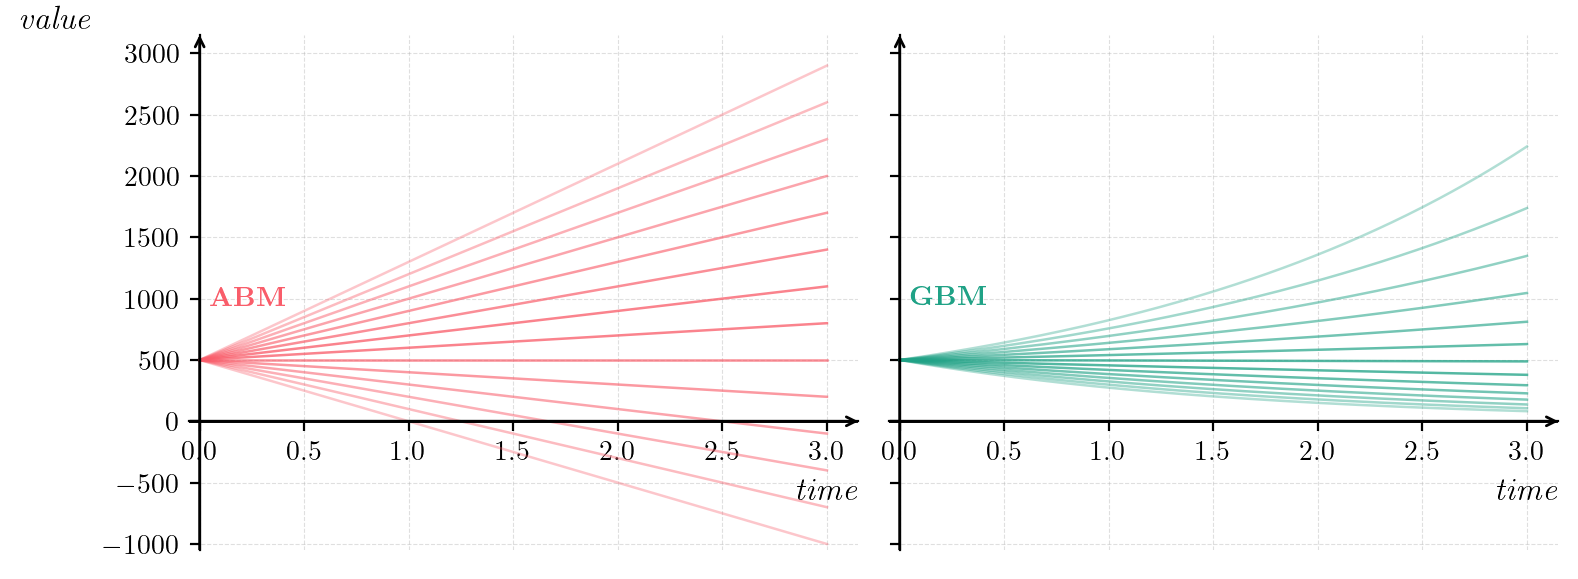

In [13]:
# Figure V.1: ABM vs GBM Side by Side –––––

# Parameters
T = 3.0
N = 200
t = np.linspace(0, T, N+1)
S0 = 500.0
ymin, ymax = -1000 * 1.05, 3000 * 1.05
xmin, xmax = -0.05, T * 1.05

# Create the figure
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8, 3), dpi=200)

# Panel 1: Arithmetic Brownian Motion
slopes = np.linspace(-500, 800, 14)
for i, r in enumerate(slopes):
    y = S0 + r * t
    alpha = 0.35 + 0.45 * (1 - abs(i - (len(slopes)-1)/2) / ((len(slopes)-1)/2))
    axes[0].plot(t, y, color=colours["2"], linewidth=0.9, alpha=alpha)

# Grid and text
axes[0].grid(True, linestyle='--', linewidth=0.4, alpha=0.4)
axes[0].text(0.05, 1000, r"\textbf{ABM}", fontsize=10, color=colours["2"], ha="left", va="center")
axes[0].axhline(0, linewidth=1.0, color="black")
axes[0].set_xlim(xmin, xmax)
axes[0].set_ylim(ymin, ymax)
axes[0].set_xlabel(r"\textit{time}", loc='right', fontsize=12)
axes[0].set_ylabel(r"\textit{value}", loc='top', rotation=0, fontsize=12)
#axes[0].set_title(r"\textbf{Arithmetic Brownian Motion}", pad=10)

# Clean axes
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['left'].set_position('zero')
axes[0].spines['bottom'].set_position('zero')

# Axis limits and arrows
axis_arrow(axes[0], (xmin, 0), (xmax, 0))
axis_arrow(axes[0], (0, ymin), (0, ymax))

# ----- Panel 2: Geometric Brownian Motion -----
growth_rates = np.linspace(-0.60, 0.50, 14)
for i, g in enumerate(growth_rates):
    y = S0 * np.exp(g * t)
    alpha = 0.35 + 0.45 * (1 - abs(i - (len(growth_rates)-1)/2) / ((len(growth_rates)-1)/2))
    axes[1].plot(t, y, color=colours["7"], linewidth=0.9, alpha=alpha)

# Grid and text
axes[1].grid(True, linestyle='--', linewidth=0.4, alpha=0.4)
axes[1].text(0.05, 1000, r"\textbf{GBM}", fontsize=10, color=colours["7"], ha="left", va="center")
axes[1].axhline(0, linewidth=1.0, color="black")
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylim(ymin, ymax)
axes[1].set_xlabel(r"\textit{time}", loc='right', fontsize=12)
#axes[1].set_title(r"\textbf{Geometric Brownian Motion}", pad=10)

# Clean axes
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['left'].set_position('zero')
axes[1].spines['bottom'].set_position('zero')

# Axis limits and arrows
axis_arrow(axes[1], (xmin, 0), (xmax, 0))
axis_arrow(axes[1], (0, ymin), (0, ymax))

# Save & show
fig.tight_layout()
fig.savefig("documentation/figures/abm-gbm-side-by-side.pdf", dpi=300)
plt.show()

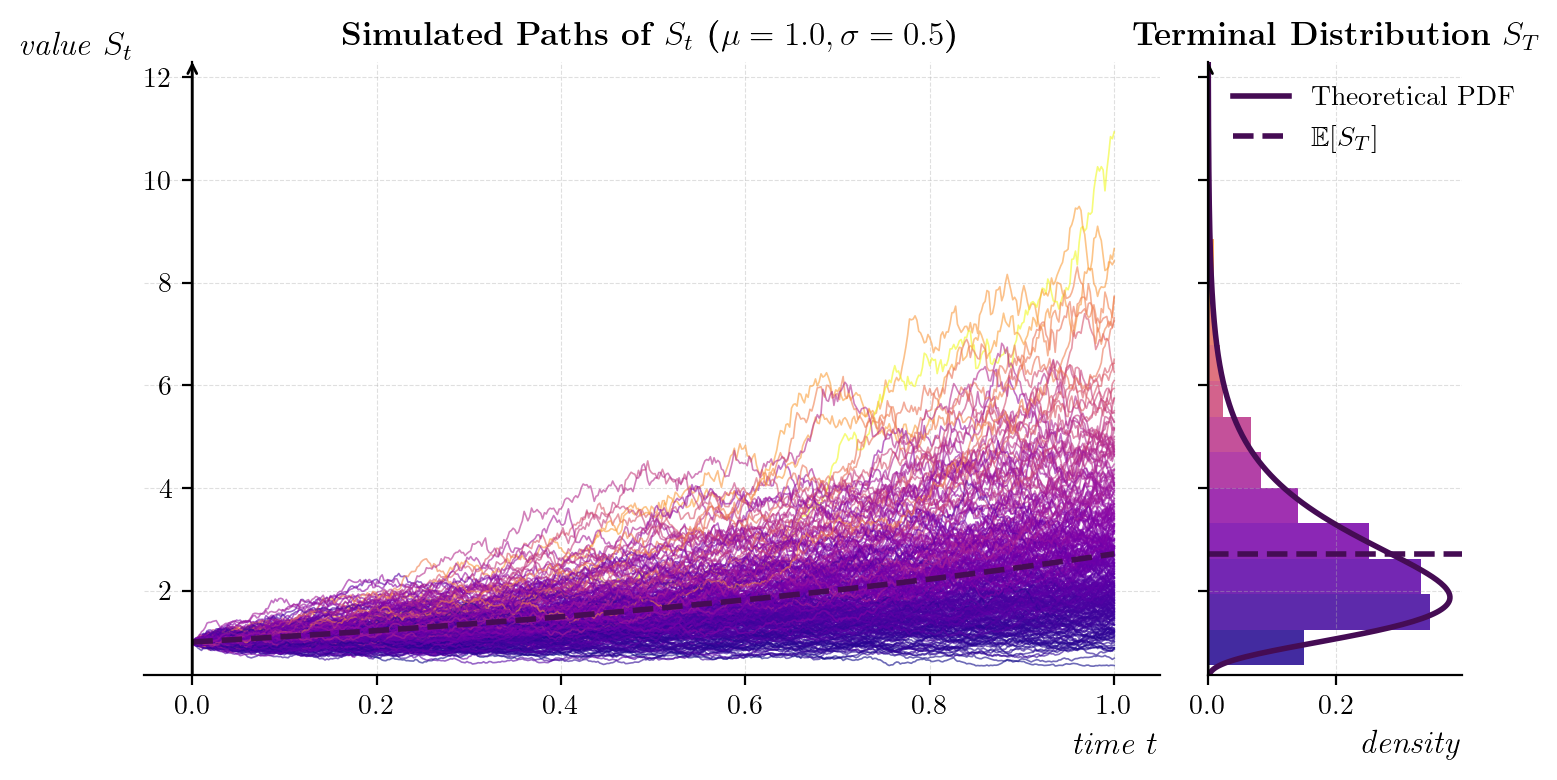

In [14]:
# Figure V.2: GBM Paths and Terminal Distribution –––––

# Parameters
mu, sigma, S0, T = 1.0, 0.5, 1.0, 1.0
N, M = 500, 300
dt = T / N
t = np.linspace(0, T, N + 1)
rng = np.random.default_rng(7)

# Simulate GBM
paths = np.empty((M, N + 1))
paths[:, 0] = S0
drift = (mu - 0.5 * sigma**2) * dt
diff = sigma * np.sqrt(dt)
for i in range(N):
    Z = rng.standard_normal(M)
    paths[:, i + 1] = paths[:, i] * np.exp(drift + diff * Z)

S_T = paths[:, -1]
E_St = S0 * np.exp(mu * t)
E_ST = S0 * np.exp(mu * T)

# Theoretical lognormal pdf
m = np.log(S0) + (mu - 0.5 * sigma**2) * T
v = sigma**2 * T
def lognormal_pdf(x, m, v):
    pdf = np.zeros_like(x, dtype=float)
    pos = x > 0
    pdf[pos] = (1.0 / (x[pos] * np.sqrt(2*np.pi*v))) * np.exp(-(np.log(x[pos]) - m)**2 / (2*v))
    return pdf

ymin = max(1e-6, np.percentile(S_T, 0.1) * 0.6)
ymax = np.percentile(S_T, 99.9) * 1.2
ygrid = np.linspace(ymin, ymax, 400)
pdf_vals = lognormal_pdf(ygrid, m, v)

# Create subplot
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True,
                         gridspec_kw={"width_ratios": [4, 1]}, dpi=200)

# --- Colormap based on terminal value ---
norm_color = Normalize(vmin=S_T.min(), vmax=S_T.max())
cmap = colormaps["plasma"]

# Simulated paths, colored by terminal value
for i in range(M):
    color = cmap(norm_color(S_T[i]))
    axes[0].plot(t, paths[i], linewidth=0.6, alpha=0.6, color=color)
axes[0].plot(t, E_St, linestyle="--", linewidth=2.0, color=colours["9"], label=r"$E[S_t]$")
axes[0].set_title(rf"\textbf{{Simulated Paths of $S_t$ ($\mu={mu}, \sigma={sigma}$)}}")
axes[0].set_xlabel(r"\textit{time} $t$", loc='right', fontsize=12)
axes[0].set_ylabel(r"\textit{value} $S_t$", loc='top', rotation=0, fontsize=12)
axes[0].grid(True, linestyle='--', linewidth=0.4, alpha=0.4)
#axes[0].legend(loc="best", frameon=False)

# Clean axes
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['left'].set_position('zero')
#axes[0].spines['bottom'].set_position('zero')

# X-axis limits
xmin, xmax = 0, T * 0.6

# Axis limits and arrows
axis_arrow(axes[0], (xmin, 0), (xmax, 0))
axis_arrow(axes[0], (0, ymin), (0, ymax))

# Terminal distribution (colored bins)
n, bins, patches = axes[1].hist(S_T, bins=15, density=True, orientation="horizontal", alpha=0.85)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
for c, p in zip(bin_centers, patches):
    plt.setp(p, 'facecolor', cmap(norm_color(c)))
axes[1].plot(pdf_vals, ygrid, linewidth=2.0, color=colours["9"], label="Theoretical PDF")
axes[1].axhline(E_ST, linestyle="--", linewidth=2.0, color=colours["9"], label=r"$\mathbb{E}[S_T]$")
axes[1].set_title(r"\textbf{Terminal Distribution $S_T$}")
axes[1].set_xlabel(r"\textit{density}", loc='right', fontsize=12)
axes[1].grid(True, linestyle='--', linewidth=0.4, alpha=0.4)
axes[1].legend(loc="upper left", frameon=False)
axes[1].set_ylim(ymin, ymax)

# Clean axes
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['left'].set_position('zero')
#axes[1].spines['bottom'].set_position('zero')

# X-axis limits
xmin, xmax = 0, max(n)*1.05
axis_arrow(axes[0], (xmin, 0), (xmax, 0))
axis_arrow(axes[1], (0, ymin), (0, ymax))

fig.tight_layout()
fig.savefig("documentation/figures/gbm-paths-and-terminal-distribution.pdf", dpi=300)
plt.show()


## **VI. Pricing Principles**

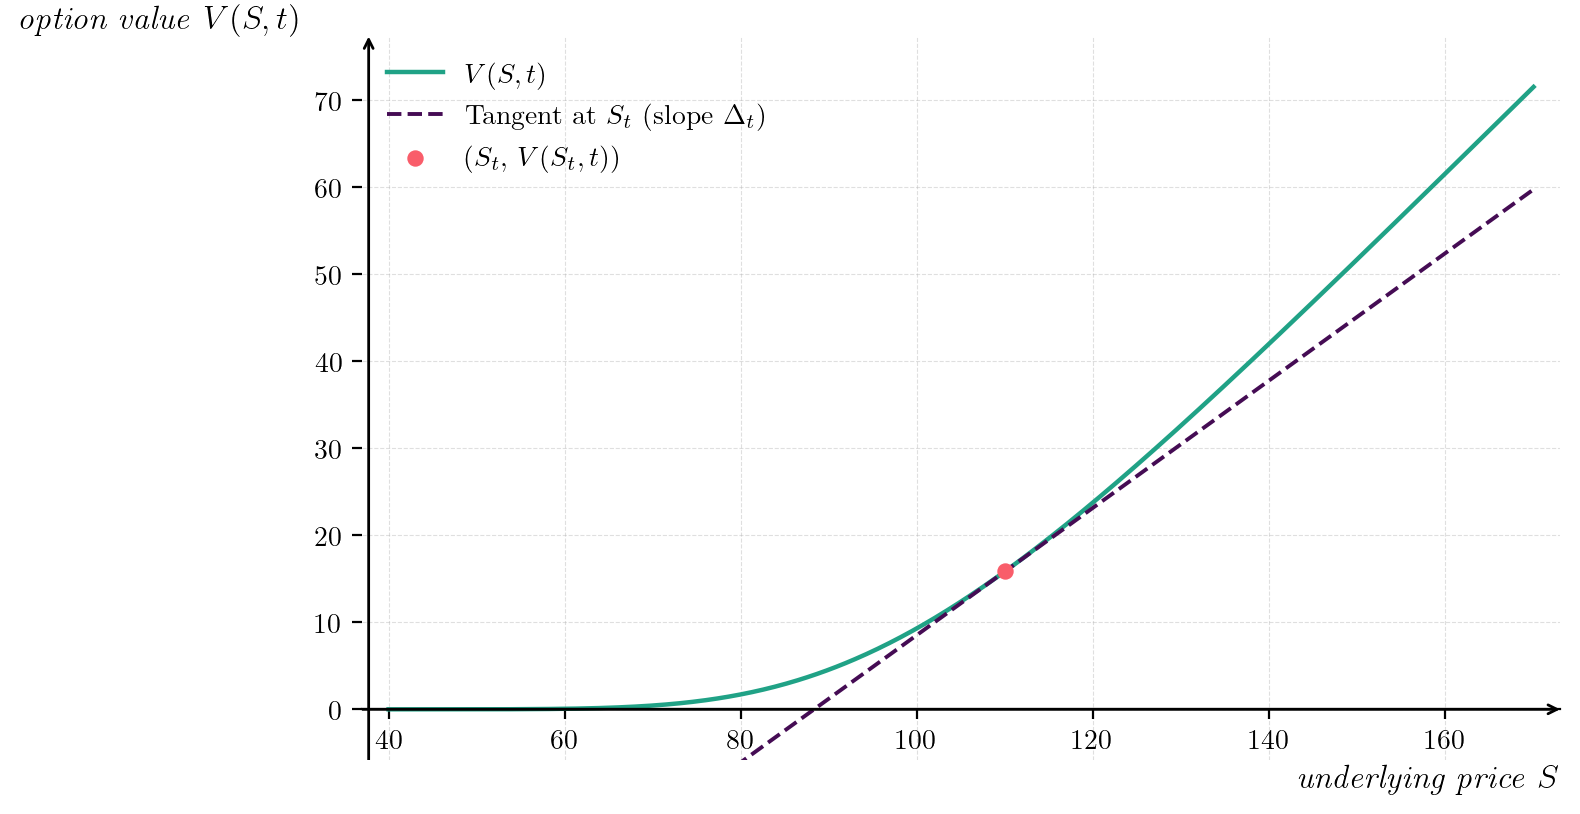

In [15]:
# Figure V.1: Local Delta-Hedge — Option Value & Tangent at S_t –––––

# Black–Scholes helpers (European call) ONLY for this figure
def bs_call_price(S, K, r, sigma, T):
    if T <= 0 or sigma <= 0:
        return max(S - K, 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    Nd1 = NormalDist().cdf(d1)
    Nd2 = NormalDist().cdf(d2)
    return S * Nd1 - K * np.exp(-r * T) * Nd2

def bs_call_delta(S, K, r, sigma, T):
    if T <= 0 or sigma <= 0:
        return 1.0 if S > K else (0.5 if S == K else 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return NormalDist().cdf(d1)

# Parameters
K, r, sigma, T = 100.0, 0.02, 0.25, 0.75
S_min, S_max = 40.0, 170.0
S_grid = np.linspace(S_min, S_max, 600)

# Choose the “current” spot S_t for annotation
S_t = 110.0
V_grid = np.array([bs_call_price(S, K, r, sigma, T) for S in S_grid])
V_t   = bs_call_price(S_t, K, r, sigma, T)
Delta_t = bs_call_delta(S_t, K, r, sigma, T)
V_tangent = V_t + Delta_t * (S_grid - S_t)

# Figure
fig, ax = plt.subplots(1, 1, figsize=(8, 4.2), dpi=200)

ax.plot(S_grid, V_grid, color=colours["7"], linewidth=1.6, label=r"$V(S,t)$")
ax.plot(S_grid, V_tangent, linestyle="--", linewidth=1.4, label=r"Tangent at $S_t$ (slope $\Delta_t$)", color=colours["9"])
ax.scatter([S_t], [V_t], s=24, zorder=3, label=r"$(S_t,\,V(S_t,t))$", color=colours["2"])

# Clean axes to match style
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_position('zero')

# Limits and axis arrows
xmin, xmax = S_min - 3, S_max + 3
y_pad = 0.08 * (V_grid.max() - V_grid.min() + 1)
ymin, ymax = V_grid.min() - y_pad, V_grid.max() + y_pad

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
axis_arrow(ax, (xmin, 0), (xmax, 0))
axis_arrow(ax, (xmin*1.02, ymin), (xmin*1.02, ymax))

# Grid, ticks, labels
ax.legend(loc='upper left', frameon=False, fontsize=10)
ax.grid(True, linestyle='--', linewidth=0.4, alpha=0.4)
ax.set_xlabel(r"\textit{underlying price} $S$", loc='right', fontsize=12)
ax.set_ylabel(r"\textit{option value} $V(S,t)$", loc='top', rotation=0, fontsize=12)
#ax.set_title(r"\textbf{Local Delta-Hedge: Option Value and Tangent at $S_t$}", fontsize=13, pad=10)

# Save and show
plt.tight_layout()
plt.savefig("documentation/figures/delta-hedge-tangent.pdf", dpi=300)
plt.show()

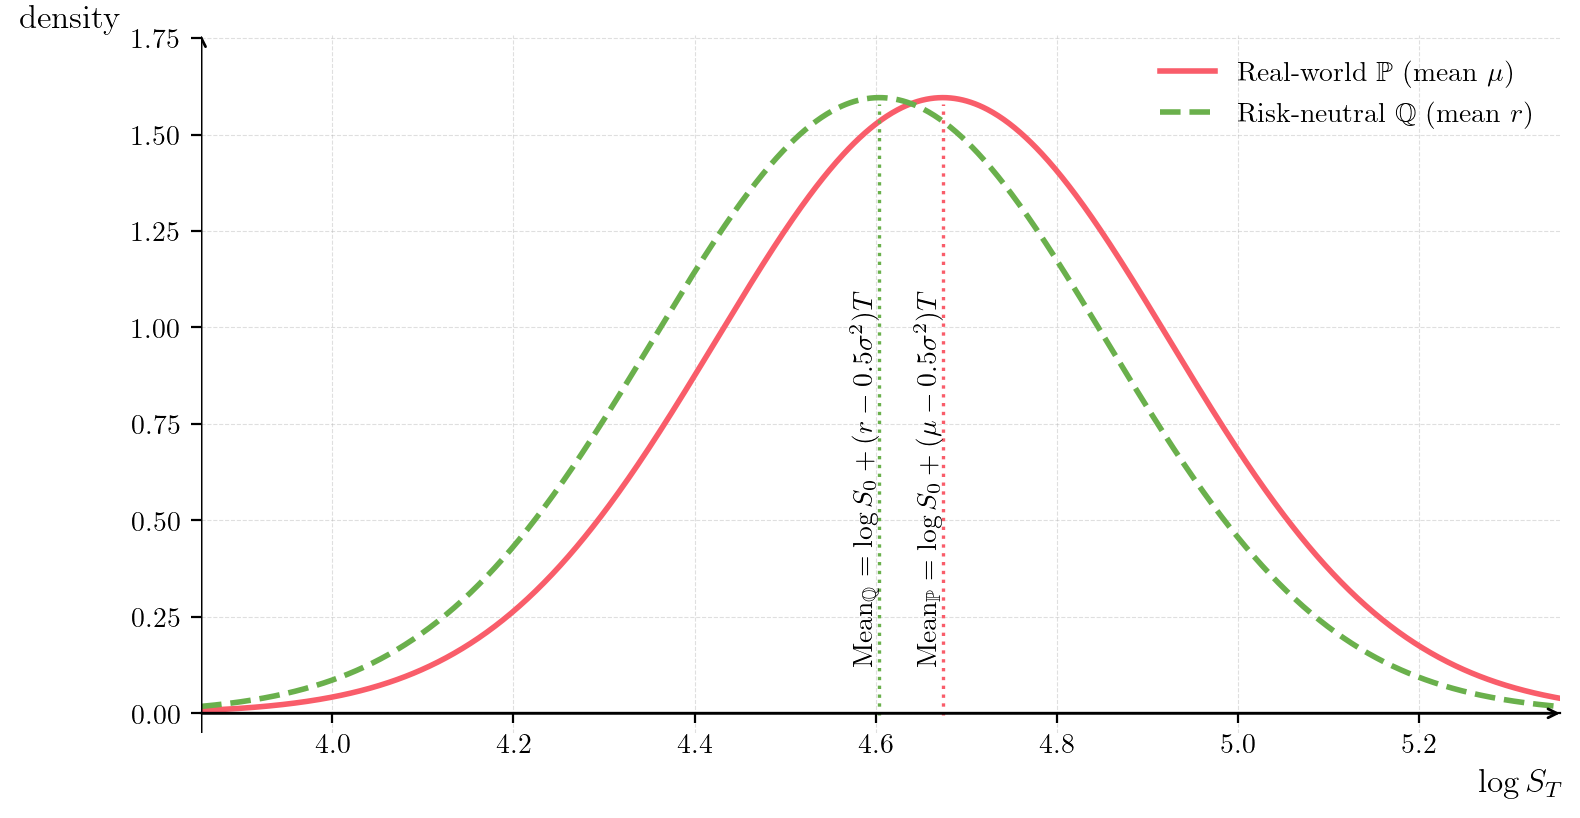

In [16]:
# Figure VI.2: Distribution Shift in Log-Space: Real-World vs Risk-Neutral –––––

# Parameters
S0 = 100.0
sigma = 0.25
T = 1.0
mu = 0.10
r = 0.03

# Log-space means and variance
m_mu = np.log(S0) + (mu - 0.5 * sigma**2) * T
m_r  = np.log(S0) + (r  - 0.5 * sigma**2) * T
v = sigma**2 * T

# Grid of log S_T
logS = np.linspace(np.log(S0) - 3*sigma*np.sqrt(T), np.log(S0) + 3*sigma*np.sqrt(T), 1000)
f_mu = norm.pdf(logS, m_mu, np.sqrt(v))
f_r  = norm.pdf(logS, m_r, np.sqrt(v))

# Create figure
fig, ax = plt.subplots(figsize=(8, 4.2), dpi=200)
ax.plot(logS, f_mu, linewidth=2.0, label=r"Real-world $\mathbb{P}$ (mean $\mu$)", color=colours["2"])
ax.plot(logS, f_r,  linewidth=2.0, linestyle="--", label=r"Risk-neutral $\mathbb{Q}$ (mean $r$)", color=colours["6"])

# Vertical mean markers
ax.axvline(m_mu, linewidth=1.2, linestyle=":", ymax=0.9, ymin=0.025, color=colours["2"])
ax.axvline(m_r,  linewidth=1.2, linestyle=":", ymax=0.9, ymin=0.025, color=colours["6"])

# Annotate means
ax.text(m_mu, ax.get_ylim()[1]*0.65, r"$\mathrm{Mean}_{\mathbb{P}}=\log S_0+(\mu-0.5\sigma^2)T$", rotation=90, va="top", ha="right", fontsize=10)
ax.text(m_r,  ax.get_ylim()[1]*0.65, r"$\mathrm{Mean}_{\mathbb{Q}}=\log S_0+(r-0.5\sigma^2)T$", rotation=90, va="top", ha="right", fontsize=10)

# Labels and style
ax.set_xlabel(r"$\log S_T$", loc='right', fontsize=12)
ax.set_ylabel(r"density", loc='top', rotation=0, fontsize=12)
#ax.set_title("Distribution Shift in Log-Space: Identical Variance, Shifted Mean\n$\\log S_T$ under Real World ($\\mu$) and Risk-Neutral ($r$)")
ax.legend(frameon=False)
ax.grid(True, linestyle='--', linewidth=0.4, alpha=0.4)

# Clean axes and arrows
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_position('zero')

xmin, xmax = logS.min(), logS.max()
ymin, ymax = -0.05, ax.get_ylim()[1] * 1.05
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
axis_arrow(ax, (xmin, 0), (xmax, 0))
axis_arrow(ax, (xmin, ymin), (xmin, ymax))

plt.tight_layout()
plt.savefig("documentation/figures/distribution-shift-risk-neutral.pdf", dpi=300)
plt.show()


## **The Black-Scholes Model**

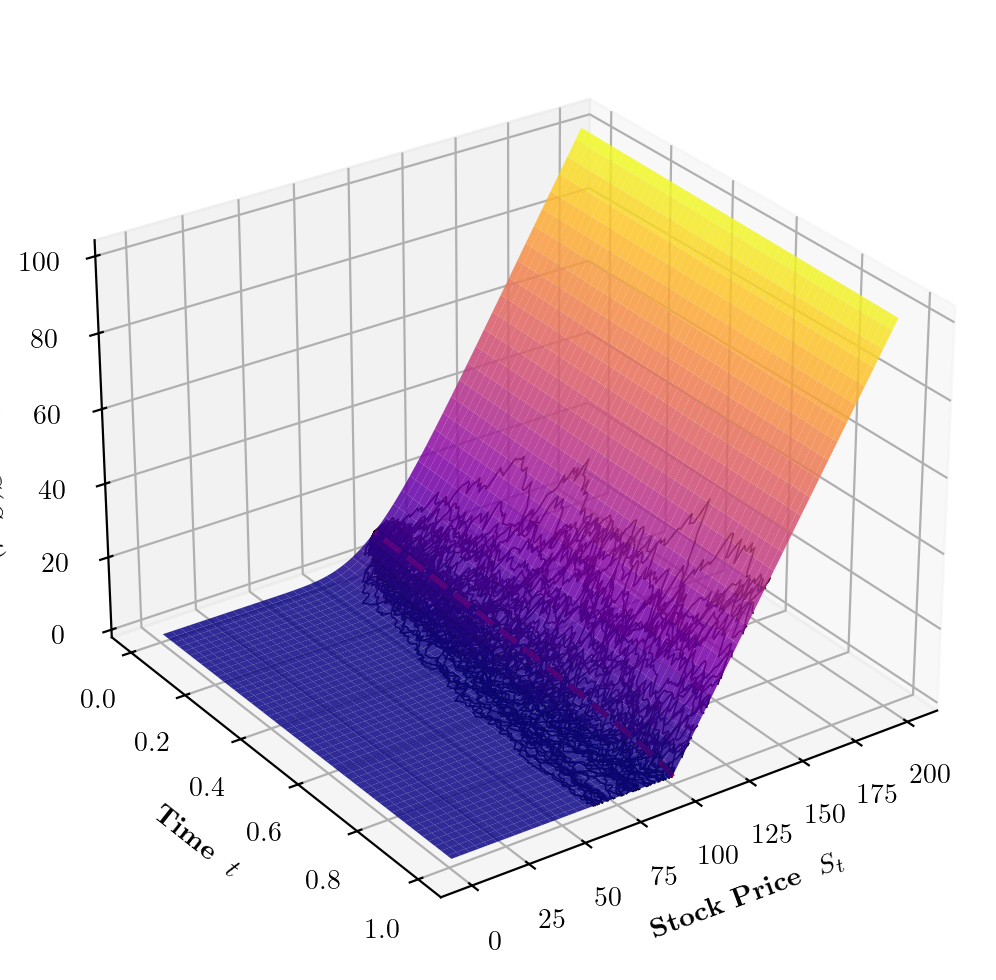

In [17]:
# Figure VII.1: Black–Scholes Surface with GBM Price Paths –––––

# Parameters
K = 100
r = 0.02
sigma = 0.2
T = 1.0
S0 = 100

# Create grid for Black–Scholes surface
nS = 150
nt = 150
S = np.linspace(1, 200, nS)
t = np.linspace(0, T, nt)

S_grid, t_grid = np.meshgrid(S, t)
tau_grid = T - t_grid  # time-to-maturity

# Black–Scholes call price
def bs_call(S, K, r, sigma, tau):
    tau = np.maximum(tau, 1e-10)  # avoid division by zero
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    return S * norm.cdf(d1) - K*np.exp(-r*tau)*norm.cdf(d2)

C_grid = bs_call(S_grid, K, r, sigma, tau_grid)

# Simulate GBM paths
n_paths = 60
n_steps = 200
dt = T / n_steps

paths = np.zeros((n_paths, n_steps+1))
paths[:, 0] = S0
t_vec = np.linspace(0, T, n_steps+1)

for i in range(n_steps):
    Z = np.random.normal(0, 1, n_paths)
    paths[:, i+1] = paths[:, i] * np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)


# Plot
fig = plt.figure(figsize=(8, 5), dpi=200)
ax = fig.add_subplot(111, projection='3d')

# Plot the Black–Scholes surface
ax.plot_surface(
    S_grid, t_grid, C_grid,
    cmap='plasma',
    alpha=0.85,
    rstride=3, cstride=3,
    linewidth=0.1,
    edgecolor='none'
)

# Plot GBM paths on the option surface
for i in range(n_paths):
    S_path = paths[i]
    # match option values on the surface for each (S,t)
    C_path = bs_call(S_path, K, r, sigma, T - t_vec)
    ax.plot(S_path, t_vec, C_path, color='black', alpha=1, linewidth=0.6)

# Strike line (vertical curve on the surface)
strike_t = np.linspace(0, T, 200)[::-1]
strike_C = bs_call(K * np.ones_like(strike_t), K, r, sigma, T - strike_t)
ax.plot(K * np.ones_like(strike_t), strike_t, strike_C, color='red', linestyle='--', linewidth=2)

# Labels and formatting
ax.set_xlabel(r"\textbf{Stock Price } $S_t$")
ax.set_ylabel(r"\textbf{Time } $t$")
ax.set_zlabel(r"\textbf{Call Value } $C(S_t,t)$")
#ax.set_title(r"\textbf{Black--Scholes Surface with GBM Price Paths}")

# Invert y-axis to have time decrease towards the viewer
ax.invert_yaxis()

# Camera angle
ax.view_init(elev=28, azim=235)

# Save and show
plt.tight_layout()
plt.savefig("documentation/figures/black-scholes-surface.pdf", dpi=300)
plt.show()

## **The Option Greeks**

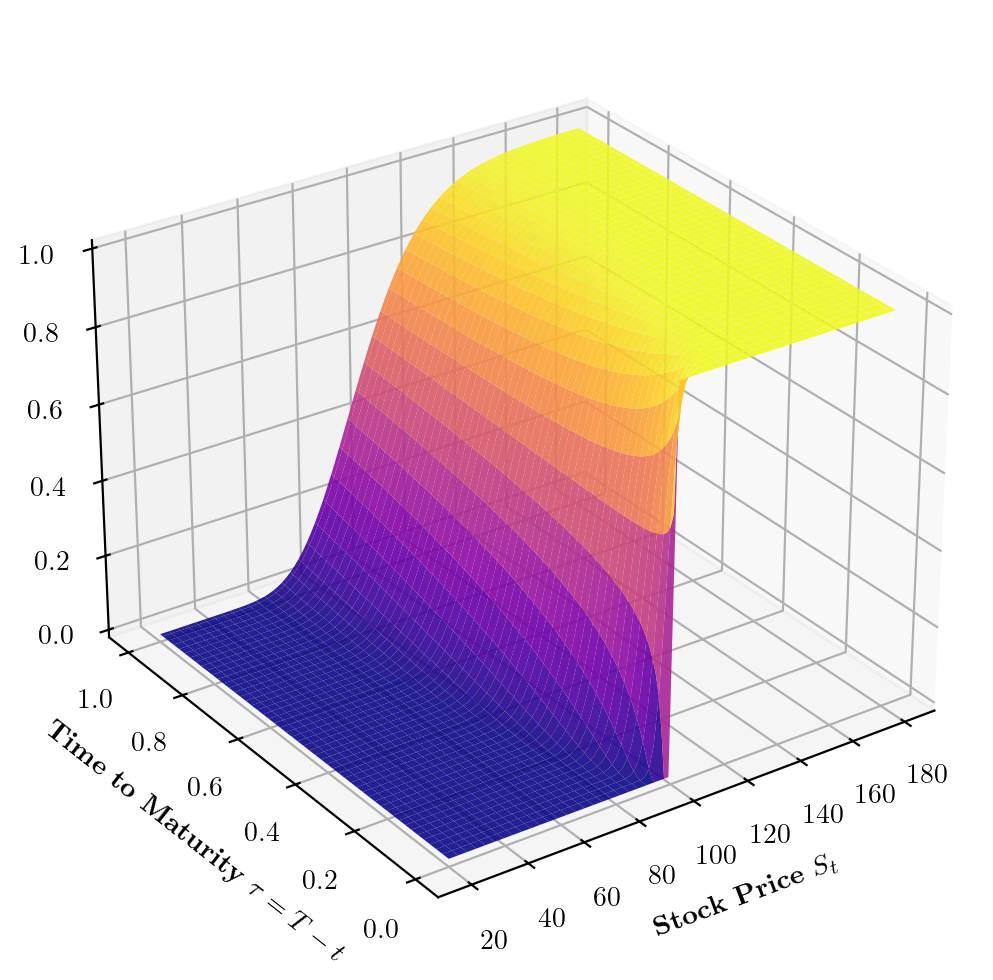

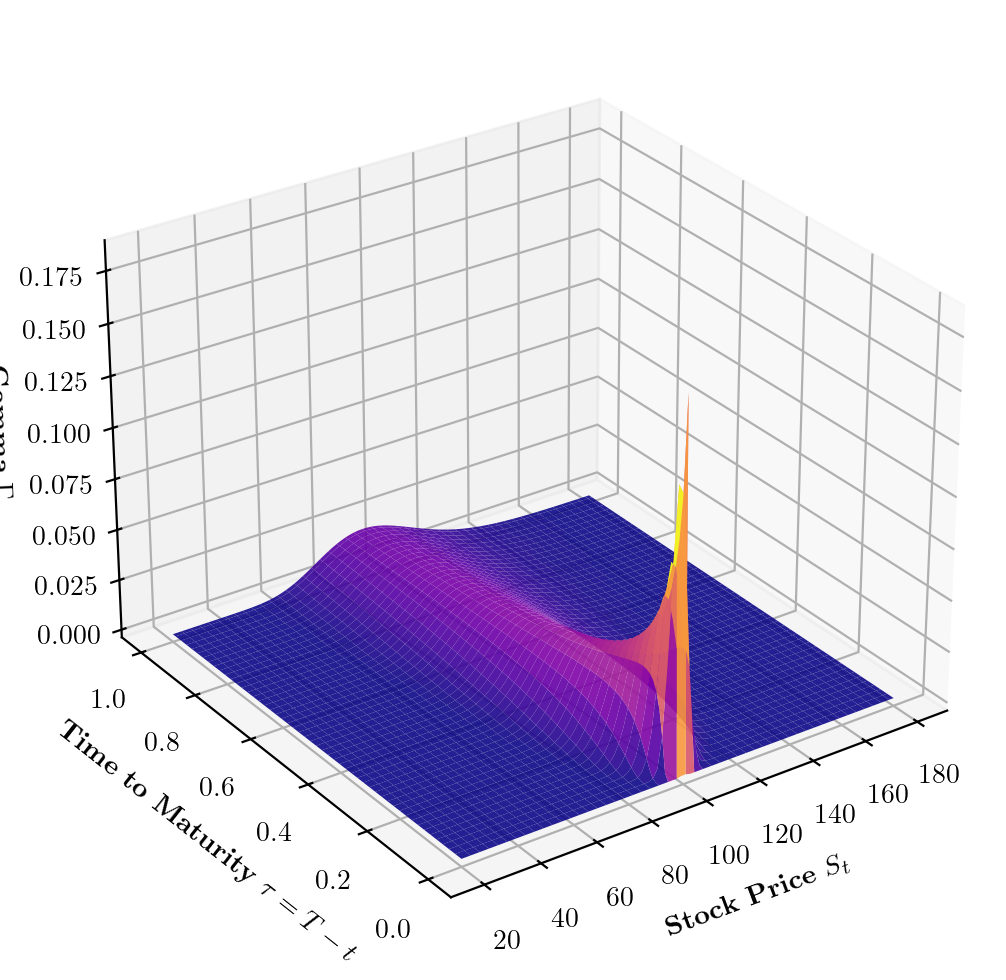

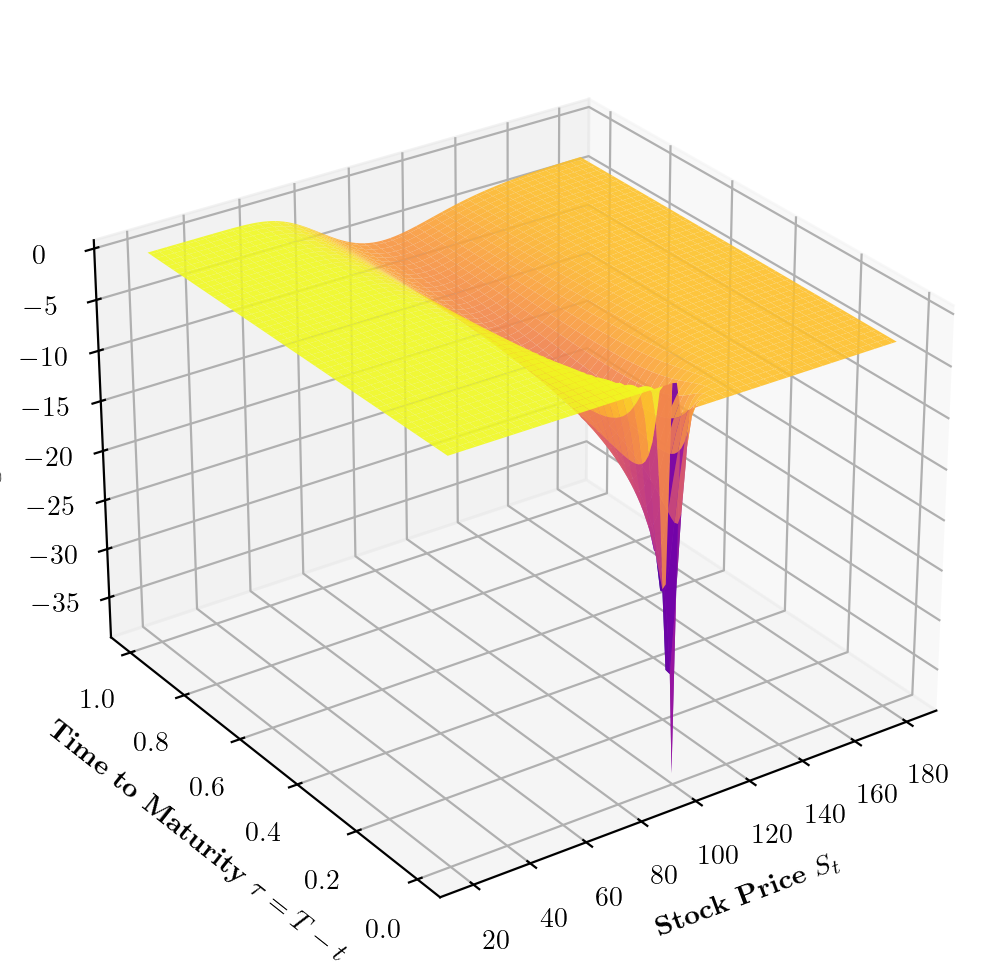

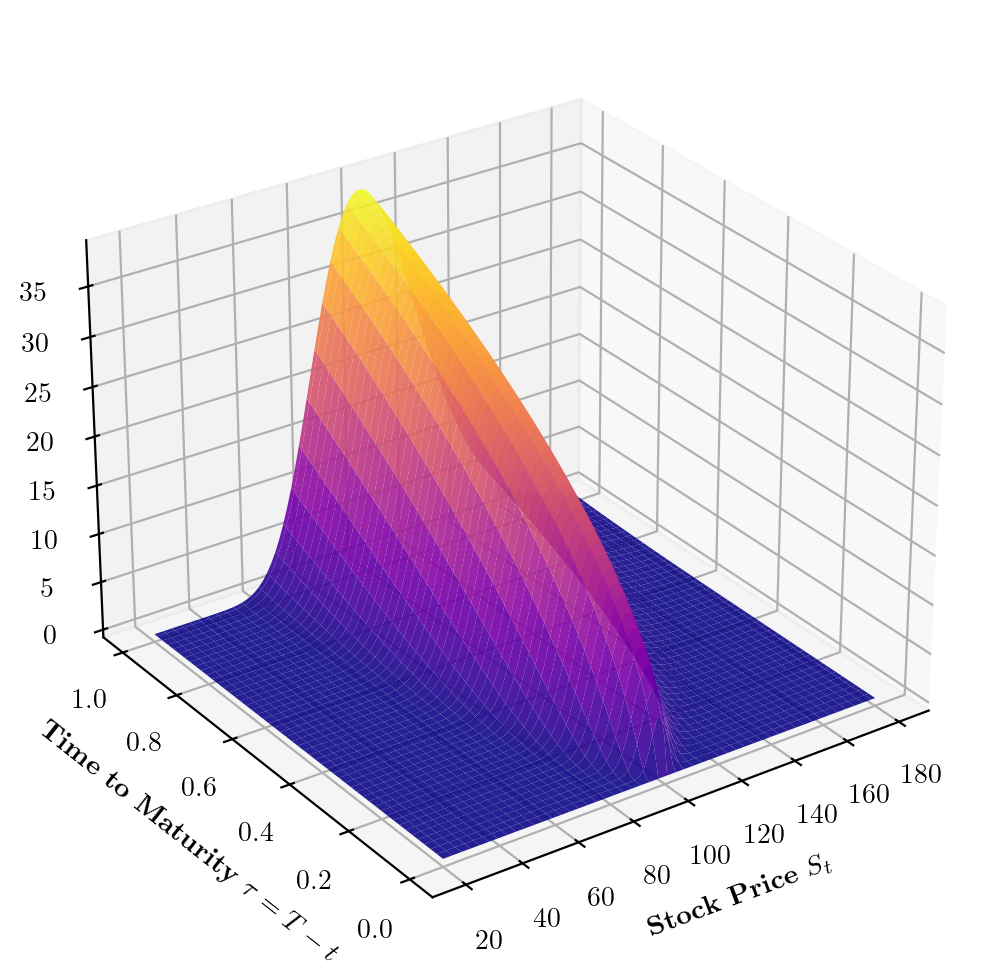

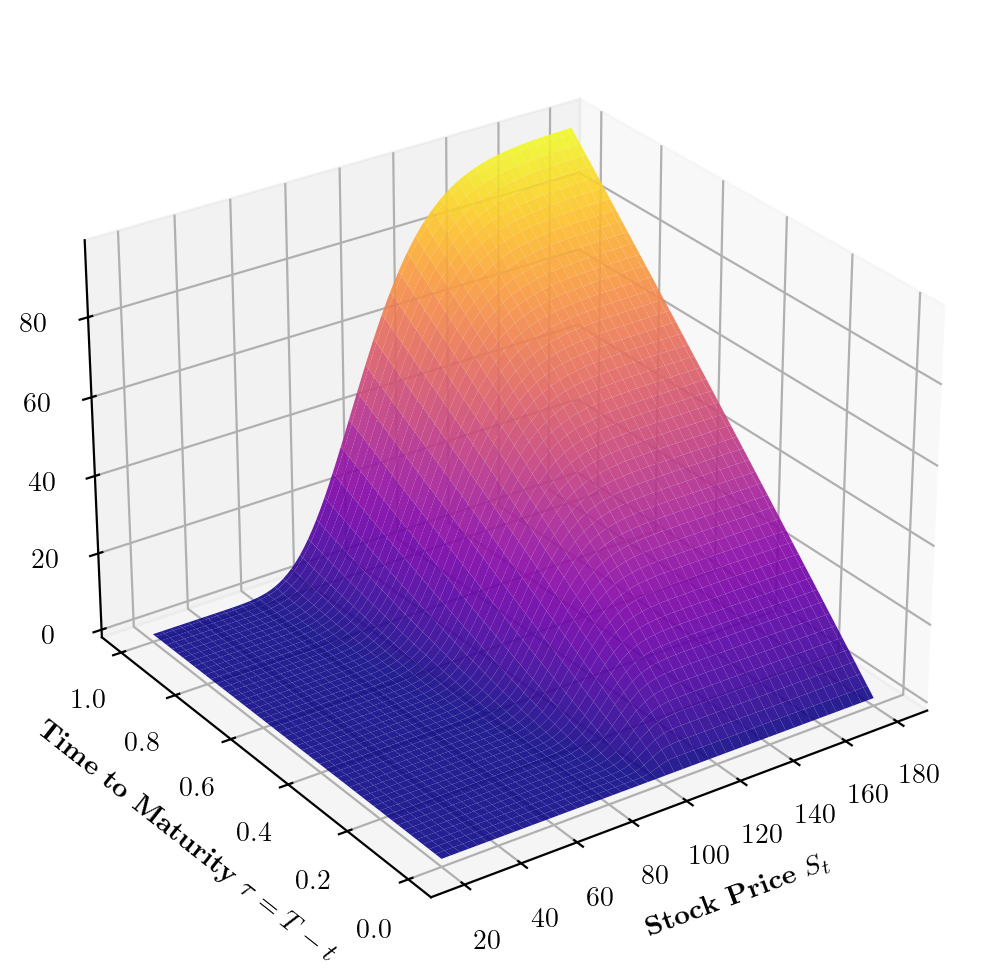

In [2]:
# Figure VIII.1-5: Black–Scholes Greeks Surfaces –––––

# Parameters
K = 100.0      # strike
r = 0.03       # risk-free rate
sigma = 0.20   # volatility
T = 1.0        # maturity in years

# Grid for S and tau = T - t
S_min, S_max = 20.0, 180.0
n_S = 100
n_tau = 100

S = np.linspace(S_min, S_max, n_S)
tau = np.linspace(1e-4, T, n_tau)  # avoid tau = 0 to prevent division by zero

S_grid, tau_grid = np.meshgrid(S, tau)

# Helper: p_+ and p_-
sqrt_tau = np.sqrt(tau_grid)
p_plus = (np.log(S_grid / K) + (r + 0.5 * sigma**2) * tau_grid) / (sigma * sqrt_tau)
p_minus = p_plus - sigma * sqrt_tau


# Black–Scholes Greeks (Call) –
# Delta
Delta = norm.cdf(p_plus)

# Gamma (same for call and put)
Gamma = norm.pdf(p_plus) / (S_grid * sigma * sqrt_tau)

# Theta (per year, for call)
Theta = (- (S_grid * norm.pdf(p_plus) * sigma) / (2.0 * sqrt_tau)
         - r * K * np.exp(-r * tau_grid) * norm.cdf(p_minus)
         )

# Vega (same for call and put)
Vega = S_grid * norm.pdf(p_plus) * sqrt_tau

# Rho (call)
Rho = K * tau_grid * np.exp(-r * tau_grid) * norm.cdf(p_minus)


# Plotting helper –
def plot_surface(X, Y, Z, title, zlabel, plotname):

    # Create figure and 3D axis
    fig = plt.figure(figsize=(8, 5), dpi=200)
    ax = fig.add_subplot(111, projection="3d")

    # Plot the surface
    surf = ax.plot_surface(
        X, Y, Z,
        cmap="plasma",
        linewidth=0,
        antialiased=True,
        alpha=0.9,
    )

    # Labels and title
    ax.set_xlabel(r"\textbf{Stock Price} $S_t$")
    ax.set_ylabel(r"\textbf{Time to Maturity} $\tau = T - t$",)
    ax.set_zlabel(zlabel)
    #ax.set_title(title, pad=15)

    # Adjust viewing angle
    ax.view_init(elev=28, azim=235)

    # Save and show
    plt.tight_layout()
    plt.savefig(f"documentation/figures/greek-surface-{plotname}.pdf", dpi=300)
    plt.show()


# Generate the five surfaces –
plot_surface(S_grid, tau_grid, Delta,
             title=r"Delta Surface $\Delta_{\text{call}}(S, \tau)$",
             zlabel=r"\textbf{Delta} $\Delta$",
             plotname="delta")

plot_surface(S_grid, tau_grid, Gamma,
             title=r"Gamma Surface $\Gamma(S, \tau)$",
             zlabel=r"\textbf{Gamma} $\Gamma$",
             plotname="gamma")

plot_surface(S_grid, tau_grid, Theta,
             title=r"Theta Surface $\Theta_{\text{call}}(S, \tau)$",
             zlabel=r"\textbf{Theta} $\Theta$",
             plotname="theta")

plot_surface(S_grid, tau_grid, Vega,
             title=r"Vega Surface $\text{Vega}(S, \tau)$",
             zlabel=r"\textbf{Vega} $\nu$",
             plotname="vega")

plot_surface(S_grid, tau_grid, Rho,
             title=r"Rho Surface $\rho_{\text{call}}(S, \tau)$",
             zlabel=r"\textbf{Rho} $\rho$",
             plotname="rho")
